In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
BATCH_SIZE = 1 # Assignment asks for SGD (batch_size=1) for most parts [cite: 100]
CLASSES_TO_KEEP = [0, 1, 2, 3, 4] # We will use digits 0-4
INPUT_SIZE = 28 * 28 # 784
OUTPUT_SIZE = 5 # 5 classes

# --- 1. Load & Filter Data ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize to range [-1, 1]
])

print("Downloading MNIST...")
train_full = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_full = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Helper function to keep only specific digits
def filter_dataset(dataset, classes):
    indices = [i for i, label in enumerate(dataset.targets) if label in classes]
    return Subset(dataset, indices)

print(f"Filtering for classes {CLASSES_TO_KEEP}...")
train_subset = filter_dataset(train_full, CLASSES_TO_KEEP)
test_subset = filter_dataset(test_full, CLASSES_TO_KEEP)

# Create DataLoaders
# We create a default loader here, but we will make custom ones later for Batch GD
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=1000, shuffle=False)

print(f"Data Ready. Training samples: {len(train_subset)}, Test samples: {len(test_subset)}")

Filtering for classes [0, 1, 2, 3, 4]...
Data Ready. Training samples: 30596, Test samples: 5139


In [17]:
# --- 2. Dynamic Neural Network Architecture ---
class FlexibleNN(nn.Module):
    def __init__(self, input_size, hidden_dims, output_size):
        super(FlexibleNN, self).__init__()
        layers = []

        # Input Layer -> First Hidden
        layers.append(nn.Linear(input_size, hidden_dims[0]))
        layers.append(nn.ReLU()) # ReLU is standard for hidden layers

        # Hidden -> Hidden (intermediate layers)
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())

        # Last Hidden -> Output
        layers.append(nn.Linear(hidden_dims[-1], output_size))

        # Combine all layers into a sequential model
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1) # Flatten image (N, 28*28)
        return self.network(x)

# --- 3. Optimizer Factory ---
def get_optimizer(model, opt_name, lr=0.001):
    # Returns the correct PyTorch optimizer based on the name
    # Parameters are strictly taken from the Assignment PDF [cite: 109-112]

    if opt_name == "SGD":
        # Standard Stochastic Gradient Descent
        return optim.SGD(model.parameters(), lr=lr)

    elif opt_name == "Batch GD":
        # Same as SGD, but we will handle the "Batch" part in the training loop
        return optim.SGD(model.parameters(), lr=lr)

    elif opt_name == "Momentum":
        # SGD with Momentum (gamma=0.9)
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    elif opt_name == "NAG":
        # Nesterov Accelerated Gradient (momentum=0.9, nesterov=True)
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

    elif opt_name == "RMSprop":
        # RMSprop (alpha=0.99, eps=1e-8)
        return optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-8)

    elif opt_name == "Adam":
        # Adam (beta1=0.9, beta2=0.999, eps=1e-8)
        return optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)

    return None

In [18]:
import time

# --- 4. Training Engine ---
def train_network(model, optimizer, loader, criterion, max_epochs=20, tolerance=1e-4):
    epoch_losses = []

    for epoch in range(max_epochs):
        running_loss = 0.0
        count = 0

        for inputs, labels in loader:
            optimizer.zero_grad()       # Clear gradients
            outputs = model(inputs)     # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward()             # Backpropagation
            optimizer.step()            # Update weights

            running_loss += loss.item()
            count += 1

        # Record average loss for this epoch
        avg_loss = running_loss / count
        epoch_losses.append(avg_loss)

        # Convergence Check (Stop if change is < 10^-4) [cite: 107]
        if len(epoch_losses) > 1:
            if abs(epoch_losses[-1] - epoch_losses[-2]) < tolerance:
                break

    return epoch_losses


In [19]:
def evaluate_accuracy(model, loader):
    model.eval()  # evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc


FAST MODE ACTIVATED.
Training on 1000 samples (instead of 30,000).
This should take ~10 seconds per experiment instead of 5 minutes.
Starting FAST Experiments...

Training Architecture: 3_Layers
  - SGD: 20 epochs (25.03s)
    Train Acc: 99.00% | Val Acc: 96.40%
  - Batch GD: 2 epochs (0.35s)
    Train Acc: 15.70% | Val Acc: 18.60%
  - Momentum: 20 epochs (32.68s)
    Train Acc: 99.70% | Val Acc: 96.80%
  - NAG: 20 epochs (35.40s)
    Train Acc: 100.00% | Val Acc: 96.80%
  - RMSprop: 20 epochs (51.95s)
    Train Acc: 99.40% | Val Acc: 96.20%
  - Adam: 20 epochs (60.47s)
    Train Acc: 100.00% | Val Acc: 97.40%

Training Architecture: 4_Layers
  - SGD: 20 epochs (26.70s)
    Train Acc: 97.90% | Val Acc: 95.20%
  - Batch GD: 2 epochs (0.50s)
    Train Acc: 19.40% | Val Acc: 21.00%
  - Momentum: 20 epochs (33.62s)
    Train Acc: 99.80% | Val Acc: 97.00%
  - NAG: 20 epochs (40.08s)
    Train Acc: 99.80% | Val Acc: 96.60%
  - RMSprop: 20 epochs (57.15s)
    Train Acc: 77.00% | Val Acc: 72.2

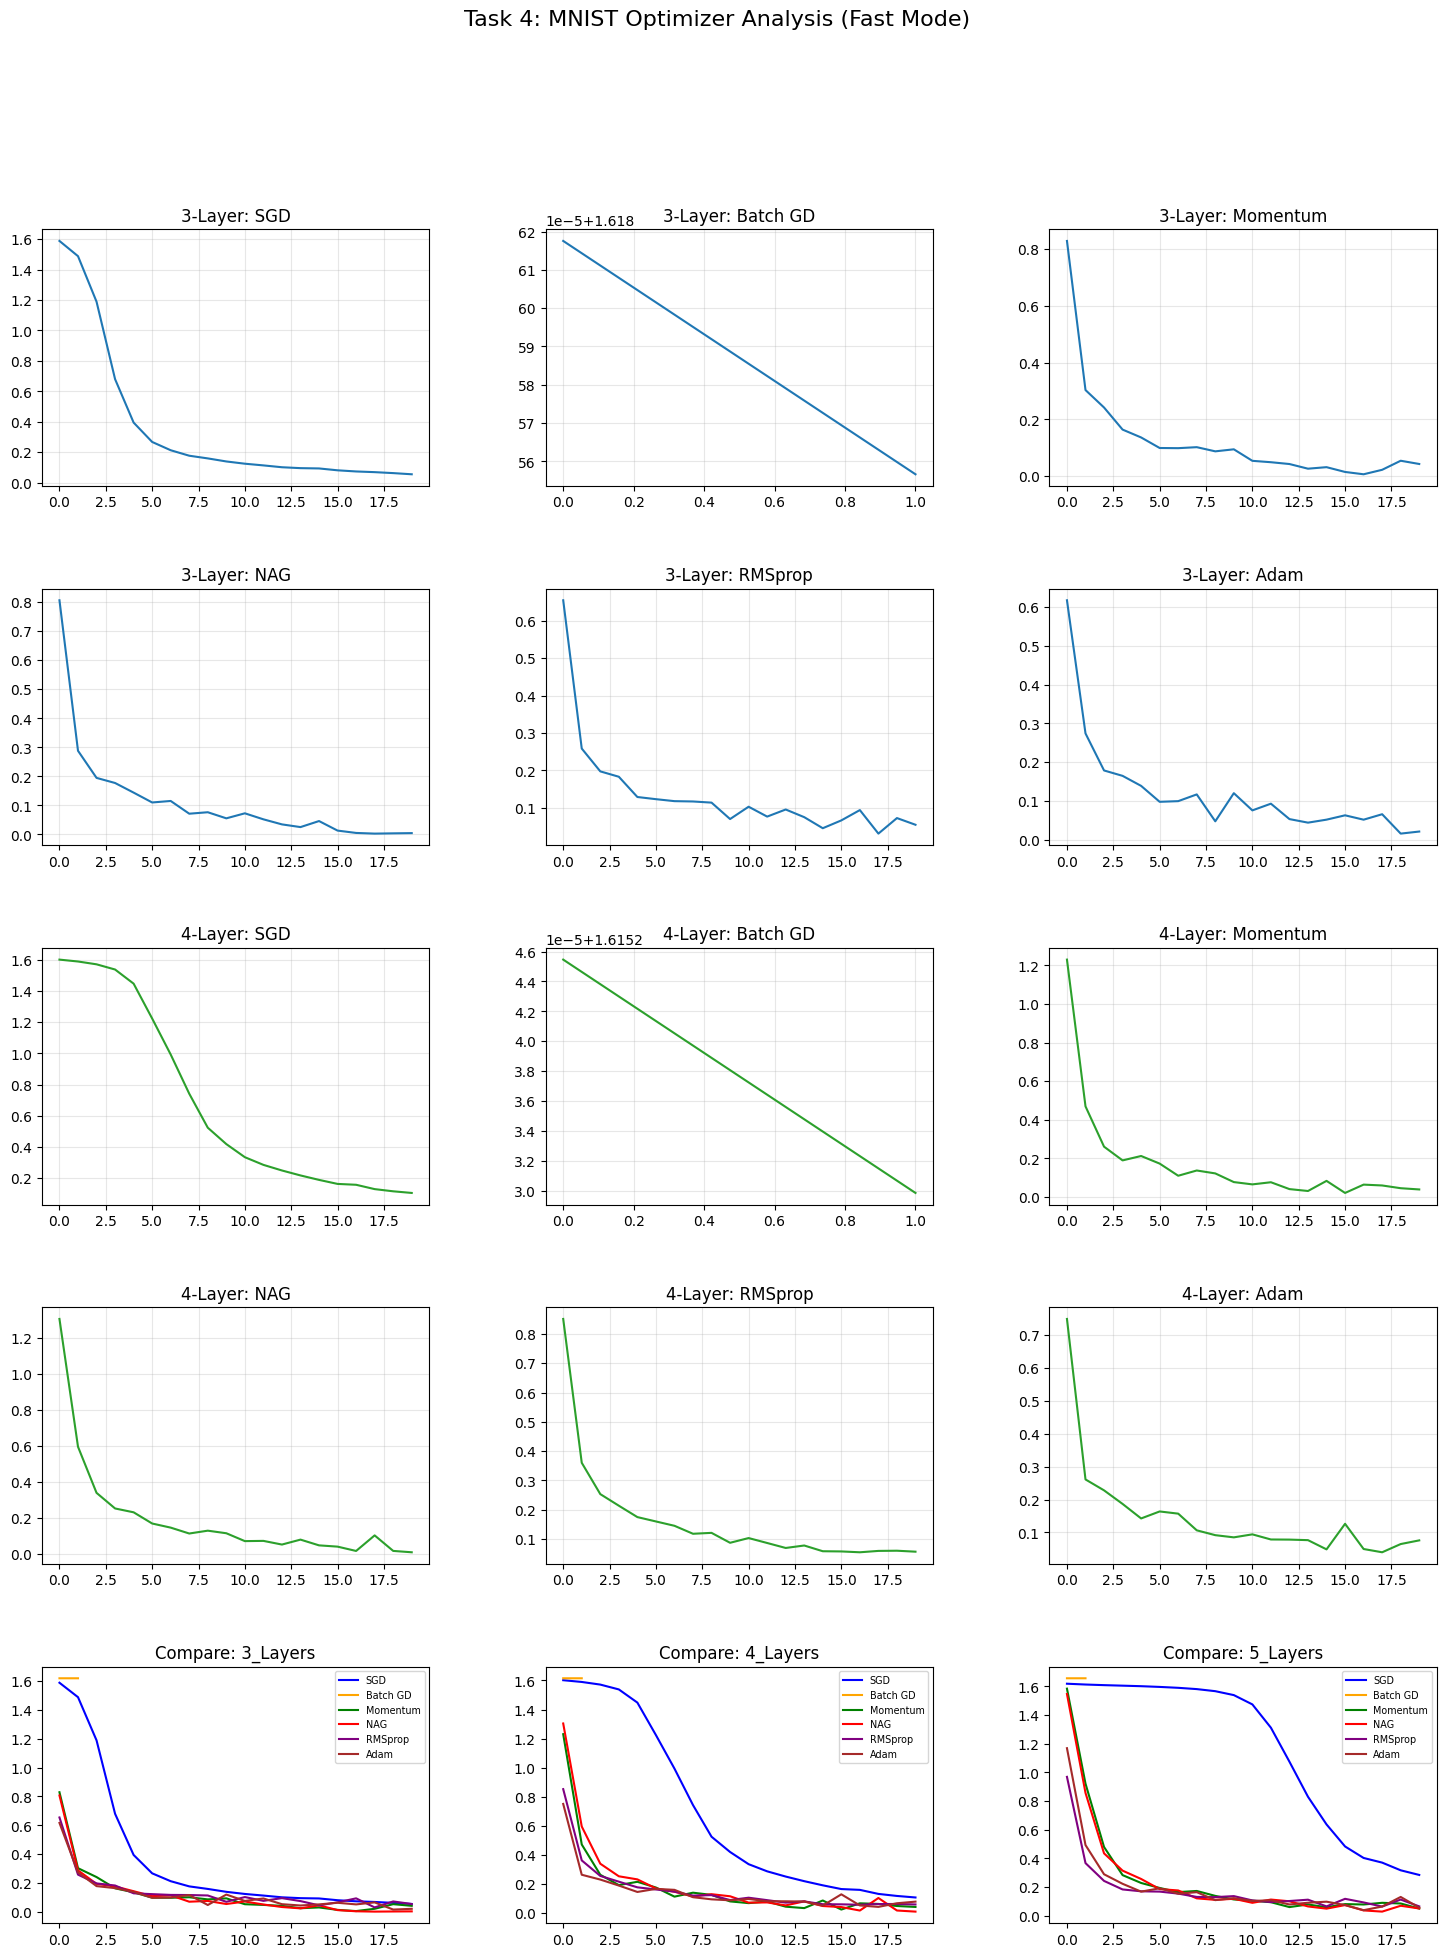

In [20]:
import time

# --- FAST VERSION: Overwrite Data Loading ---

# We take the existing full subset and slice it down
# From ~30,000 images -> 1,000 images
# From ~5,000 test images -> 500 test images

indices = np.arange(1000) # Only first 1000
train_subset_small = Subset(train_subset, indices)

test_indices = np.arange(500)
test_subset_small = Subset(test_subset, test_indices)

# Re-create DataLoaders with the small dataset
# Note: We keep batch_size=1 to satisfy the assignment rule,
# but now the loop is short.
train_loader_fast = DataLoader(train_subset_small, batch_size=1, shuffle=True)
test_loader_fast = DataLoader(test_subset_small, batch_size=1000, shuffle=False)

# Special Loader for Batch GD (uses all 1000 images at once)
batch_gd_loader_fast = DataLoader(train_subset_small, batch_size=len(train_subset_small), shuffle=True)

print(f"FAST MODE ACTIVATED.")
print(f"Training on {len(train_subset_small)} samples (instead of 30,000).")
print("This should take ~10 seconds per experiment instead of 5 minutes.")


# --- Updated FAST Training Cell ---

# Configuration
MAX_EPOCHS = 20
architectures = {
    "3_Layers": [128, 64, 32],
    "4_Layers": [128, 64, 32, 16],
    "5_Layers": [128, 64, 32, 16, 8]
}
opt_names = ["SGD", "Batch GD", "Momentum", "NAG", "RMSprop", "Adam"]
results = {arch: {} for arch in architectures}

train_acc_results = {arch: {} for arch in architectures}
val_acc_results   = {arch: {} for arch in architectures}

print("Starting FAST Experiments...")

for arch_name, hidden_dims in architectures.items():
    print(f"\nTraining Architecture: {arch_name}")

    for opt_name in opt_names:
        model = FlexibleNN(INPUT_SIZE, hidden_dims, OUTPUT_SIZE)
        optimizer = get_optimizer(model, opt_name)
        criterion = nn.CrossEntropyLoss()

        # USE THE FAST LOADERS
        if opt_name == "Batch GD":
            current_loader = batch_gd_loader_fast
        else:
            current_loader = train_loader_fast # Batch size 1, but only 1000 items

        start = time.time()
        losses = train_network(model, optimizer, current_loader, criterion, MAX_EPOCHS)
        duration = time.time() - start

        results[arch_name][opt_name] = losses
        print(f"  - {opt_name}: {len(losses)} epochs ({duration:.2f}s)")

        # Compute accuracies
        train_acc = evaluate_accuracy(model, train_loader_fast)
        val_acc   = evaluate_accuracy(model, test_loader_fast)

        train_acc_results[arch_name][opt_name] = train_acc
        val_acc_results[arch_name][opt_name]   = val_acc

        print(f"    Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

print("\n=== TRAINING ACCURACY ===")
for arch in architectures:
    print(f"\n{arch}")
    for opt in opt_names:
        print(f"{opt:10s}: {train_acc_results[arch][opt]:.2f}%")

print("\n=== VALIDATION ACCURACY ===")
for arch in architectures:
    print(f"\n{arch}")
    for opt in opt_names:
        print(f"{opt:10s}: {val_acc_results[arch][opt]:.2f}%")


# --- Plotting Code (Same as before) ---
print("\nGenerating 15-Plot Grid...")
fig, axes = plt.subplots(5, 3, figsize=(18, 22))
fig.suptitle(f"Task 4: MNIST Optimizer Analysis (Fast Mode)", fontsize=16)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
axes_flat = axes.flatten()

# Group 1: 3-Layer
for i, opt in enumerate(opt_names):
    ax = axes_flat[i]
    ax.plot(results["3_Layers"][opt], color='tab:blue')
    ax.set_title(f"3-Layer: {opt}")
    ax.grid(alpha=0.3)

# Group 2: 4-Layer
for i, opt in enumerate(opt_names):
    ax = axes_flat[i+6]
    ax.plot(results["4_Layers"][opt], color='tab:green')
    ax.set_title(f"4-Layer: {opt}")
    ax.grid(alpha=0.3)

# Group 3: Comparisons
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
for i, arch in enumerate(["3_Layers", "4_Layers", "5_Layers"]):
    ax = axes_flat[12+i]
    for j, opt in enumerate(opt_names):
        ax.plot(results[arch][opt], label=opt, color=colors[j])
    ax.set_title(f"Compare: {arch}")
    ax.legend(fontsize='x-small')

plt.show()

In [21]:
best_arch = None
best_opt = None
best_val = 0

for arch in val_acc_results:
    for opt in val_acc_results[arch]:
        if val_acc_results[arch][opt] > best_val:
            best_val = val_acc_results[arch][opt]
            best_arch = arch
            best_opt = opt

print(f"\n🏆 Best Model: {best_arch} with {best_opt}")
print(f"Validation Accuracy: {best_val:.2f}%")



🏆 Best Model: 3_Layers with Adam
Validation Accuracy: 97.40%


In [22]:
hidden_dims = architectures[best_arch]
model = FlexibleNN(INPUT_SIZE, hidden_dims, OUTPUT_SIZE)
optimizer = get_optimizer(model, best_opt)
criterion = nn.CrossEntropyLoss()

if best_opt == "Batch GD":
    loader = batch_gd_loader_fast
else:
    loader = train_loader_fast

train_network(model, optimizer, loader, criterion)


[0.6181424226244034,
 0.2775362839322238,
 0.17983693563848147,
 0.1740672682317226,
 0.15021913756692185,
 0.11801726388153068,
 0.13561344773149162,
 0.09437889202756489,
 0.10296331836399866,
 0.07054915679418988,
 0.0854801820286481,
 0.12317187702027528,
 0.08184382928366828,
 0.07119722122196248,
 0.07960586653876076,
 0.10305527772493628,
 0.020764210220709386,
 0.03488687159869049,
 0.07368442905370431,
 0.047420675831028956]

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_conf_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    return confusion_matrix(all_labels, all_preds)


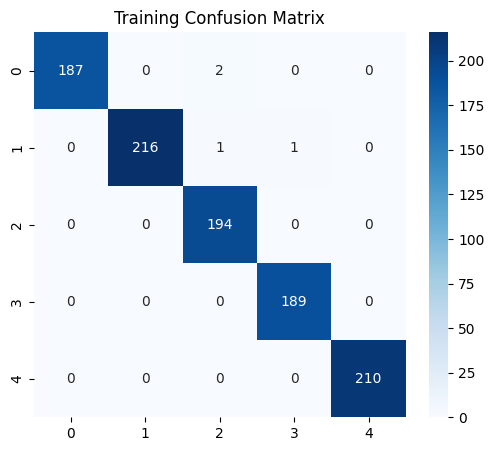

Training Accuracy: 99.60%


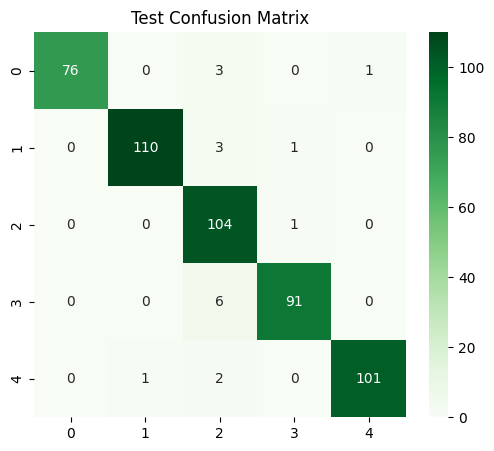

Test Accuracy: 96.40%


In [24]:
train_cm = get_conf_matrix(model, train_loader_fast)
train_acc = evaluate_accuracy(model, train_loader_fast)

plt.figure(figsize=(6,5))
sns.heatmap(train_cm, annot=True, fmt='d', cmap="Blues")
plt.title("Training Confusion Matrix")
plt.show()

print(f"Training Accuracy: {train_acc:.2f}%")


test_cm = get_conf_matrix(model, test_loader_fast)
test_acc = evaluate_accuracy(model, test_loader_fast)

plt.figure(figsize=(6,5))
sns.heatmap(test_cm, annot=True, fmt='d', cmap="Greens")
plt.title("Test Confusion Matrix")
plt.show()

print(f"Test Accuracy: {test_acc:.2f}%")
